# Image Examples

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from htc.cpp import map_label_image
from htc.evaluation.model_comparison.paper_runs import collect_comparison_runs
from htc.fonts.set_font import set_font
from htc.models.image.DatasetImage import DatasetImage
from htc.settings import settings
from htc.settings_seg import settings_seg
from htc.tivita.DataPath import DataPath
from htc.utils.Config import Config
from htc.utils.sqldf import sqldf

set_font()

In [2]:
df_runs = collect_comparison_runs(settings_seg.model_comparison_timestamp)
rows = []

for i, row_runs in df_runs.iterrows():
    for model_type in ["rgb", "param", "hsi"]:
        run_dir = settings.training_dir / row_runs["model"] / row_runs[f"run_{model_type}"]
        df_test = pd.read_pickle(run_dir / "test_table.pkl.xz")
        df_test["subject_name"], df_test["timestamp"] = zip(*df_test["image_name"].map(lambda x: x.split("#")))

        for j, row_test in df_test.iterrows():
            rows.append(
                [
                    row_runs["name"],
                    model_type,
                    row_test["subject_name"],
                    row_test["timestamp"],
                    row_test["dice_metric_image"],
                    row_test["surface_distance_metric_image"],
                    row_test[settings_seg.nsd_aggregation],
                ]
            )

df = pd.DataFrame(rows, columns=["name", "model_type", "subject_name", "timestamp", "dice", "asd", "nsd"])
df

,name,model_type,subject_name,timestamp,dice,asd,nsd
0,pixel,rgb,P043,2019_12_20_10_05_27,0.590306,79.360576,0.230037
1,pixel,rgb,P043,2019_12_20_10_05_48,0.597540,77.982277,0.234546
2,pixel,rgb,P043,2019_12_20_10_07_51,0.624340,72.356425,0.237203
3,pixel,rgb,P043,2019_12_20_10_06_32,0.672655,54.653330,0.235799
4,pixel,rgb,P043,2019_12_20_10_07_28,0.664267,57.748241,0.216995
...,...,...,...,...,...,...,...
2485,image,hsi,P072,2020_08_08_14_27_44,0.899085,9.660676,0.818683
2486,image,hsi,P072,2020_08_08_18_05_01,0.815300,8.609488,0.679935
2487,image,hsi,P072,2020_08_08_18_04_41,0.795383,10.959931,0.688699
2488,image,hsi,P072,2020_08_08_18_05_43,0.800309,10.622976,0.703586


## Min, Median and Max Image

In [3]:
df_dice = sqldf(
    """
    SELECT subject_name, timestamp, model_type, AVG(dice) AS dice
    FROM df
    WHERE model_type = 'hsi'
    GROUP BY subject_name, timestamp, model_type
    ORDER BY dice
"""
)

image_min = df_dice.iloc[round(0.05 * len(df_dice))]
image_median = df_dice.iloc[round(0.50 * len(df_dice))]
image_max = df_dice.iloc[round(0.95 * len(df_dice))]

df_dice

,subject_name,timestamp,model_type,dice
0,P072,2020_08_08_13_14_44,hsi,0.515574
1,P068,2020_07_20_18_17_26,hsi,0.544292
2,P068,2020_07_20_18_16_45,hsi,0.646181
3,P072,2020_08_08_12_56_43,hsi,0.652313
4,P072,2020_08_08_13_15_14,hsi,0.676886
...,...,...,...,...
161,P043,2019_12_20_12_40_47,hsi,0.962693
162,P068,2020_07_20_18_15_18,hsi,0.962726
163,P062,2020_05_15_18_36_47,hsi,0.964458
164,P068,2020_07_20_18_14_03,hsi,0.964573


In [4]:
image_min

subject_name                   P068
timestamp       2020_07_20_18_22_34
model_type                      hsi
dice                       0.692243
Name: 8, dtype: object

In [5]:
image_median

subject_name                   P062
timestamp       2020_05_15_18_45_24
model_type                      hsi
dice                       0.821613
Name: 83, dtype: object

In [6]:
image_max

subject_name                   P043
timestamp       2019_12_20_12_40_29
model_type                      hsi
dice                       0.960902
Name: 158, dtype: object

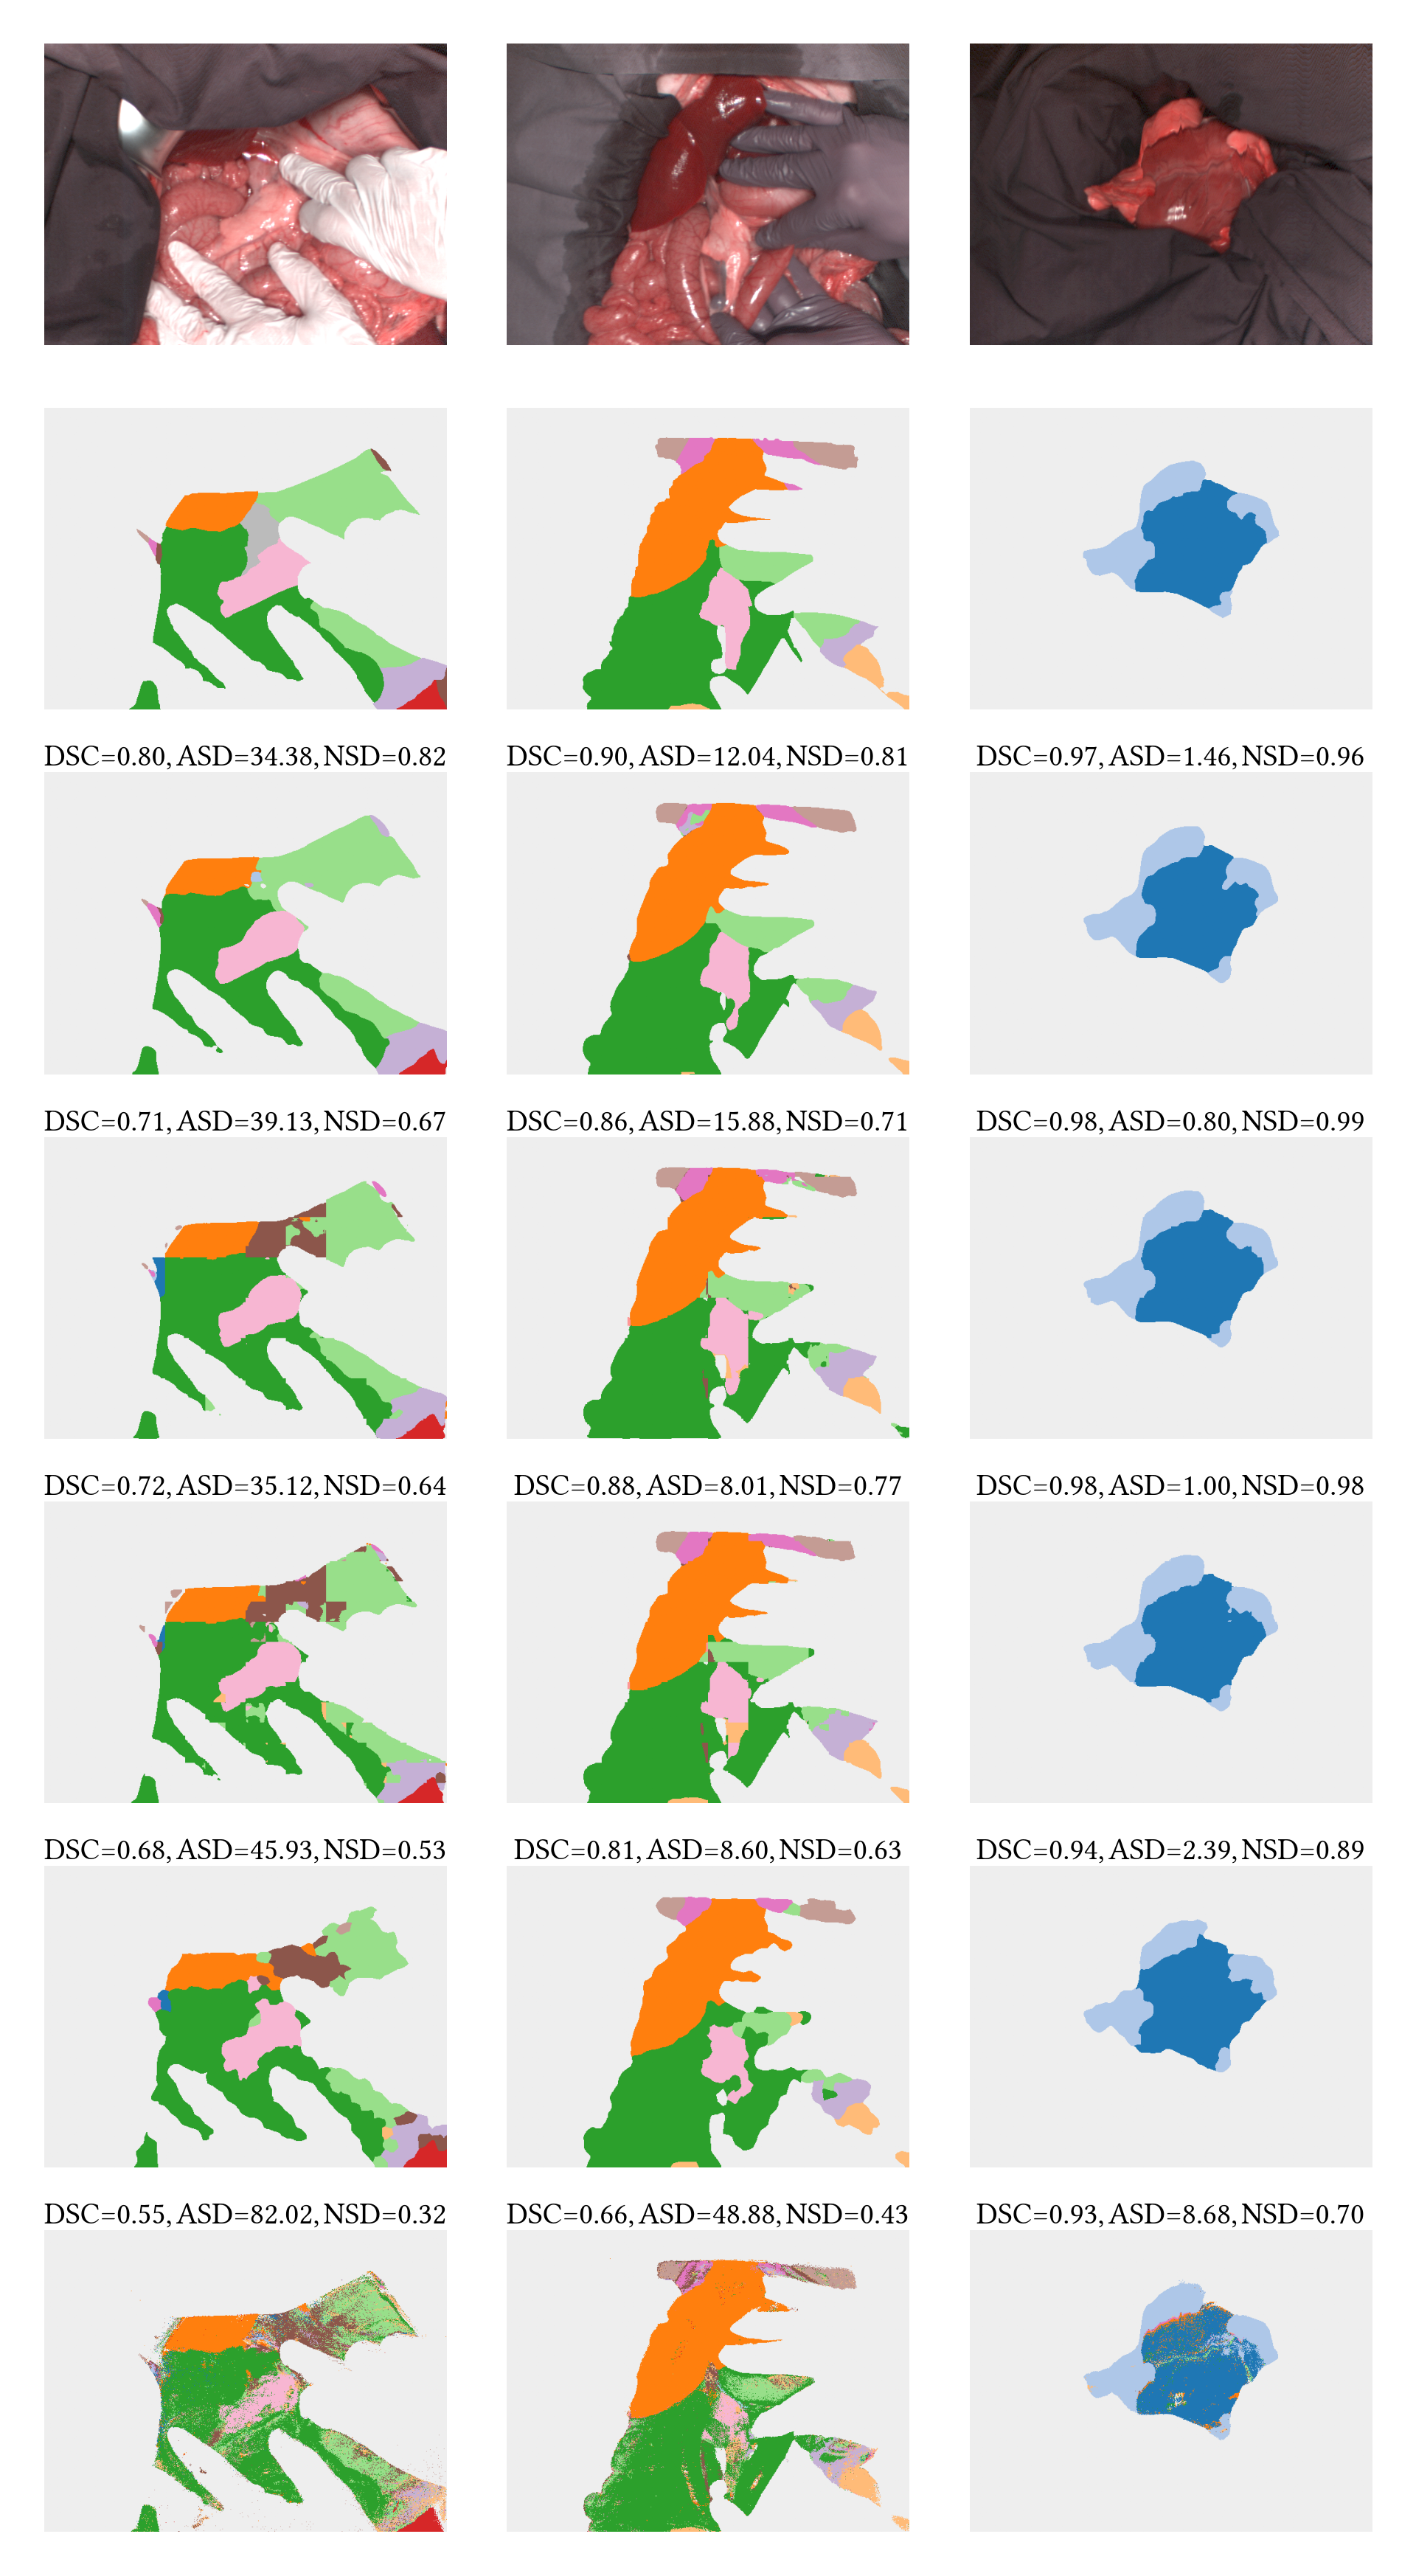

In [7]:
# Plot grid of figures
label_mapping = settings_seg.label_mapping
label_mapping.label_colors = settings_seg.label_colors_paper
cases = [image_min, image_median, image_max]
fig, axes = plt.subplots(len(df_runs) + 2, len(cases), figsize=(3, 7), dpi=600)
fig.subplots_adjust(hspace=-0.6, wspace=0.15, left=0, right=1, bottom=0, top=1)

# Plot RGB and GT
for i, img in enumerate(cases):
    path = DataPath.from_image_name(f"{img.subject_name}#{img.timestamp}")
    config = Config({"label_mapping": label_mapping, "input/n_channels": 3, "input/preprocessing": None})
    dataset = DatasetImage([path], train=False, config=config)
    sample = dataset[0]

    # RGB
    rgb = sample["features"].numpy()
    rgb = (rgb * 255).astype(np.uint8)
    axes[0, i].imshow(rgb, origin="lower")
    axes[0, i].axis("off")

    # GT
    seg_image = map_label_image(sample["labels"], label_mapping).numpy()
    axes[1, i].imshow(seg_image, origin="lower")
    axes[1, i].axis("off")

# Plot predictions
for r, row_idx in enumerate(reversed(df_runs.index)):
    row = df_runs.loc[row_idx]
    for i, img in enumerate(cases):
        run_dir = settings.training_dir / row["model"] / row["run_hsi"]
        seg = np.load(run_dir / "predictions" / f"{img.subject_name}#{img.timestamp}.npy")
        seg = np.argmax(seg, axis=0)

        entry = df.query('model_type == "hsi" and timestamp == @img.timestamp and name == @row["name"]')
        dice = entry["dice"].item()
        asd = entry["asd"].item()
        nsd = entry["nsd"].item()

        seg_image = map_label_image(seg, label_mapping)

        axes[r + 2, i].imshow(seg_image, origin="lower")
        axes[r + 2, i].axis("off")
        axes[r + 2, i].set_title(f"DSC={dice:.02f}, ASD={asd:.02f}, NSD={nsd:.02f}", fontsize=4.95, y=0.9)

for ax in axes.flatten():
    ax.invert_yaxis()

fig.savefig(settings_seg.paper_dir / "image_examples_images.pdf")

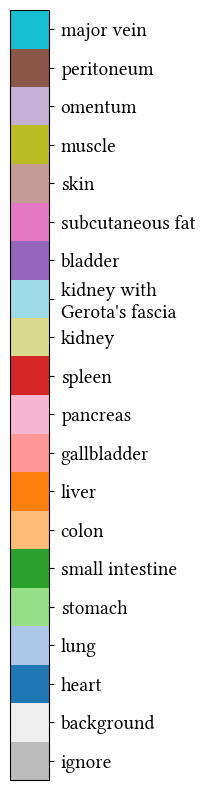

In [8]:
# Colorbar based on the label names/colors
cmap = mpl.colors.ListedColormap(list(settings_seg.label_colors_paper.values()))
bounds = list(range(len(settings_seg.label_colors_paper)))
bounds.append(max(bounds) + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(0.5, 10), dpi=100)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax)

tick_names = [settings_seg.labels_paper_renaming.get(l, l) for l in settings_seg.label_colors_paper.keys()]
tick_names = [l.replace("<br>", "\n") for l in tick_names]

# We want the ticks to be placed in the middle of the box
r = cbar.vmax - cbar.vmin
cbar.set_ticks([cbar.vmin + r / len(tick_names) * (0.5 + i) for i in range(len(tick_names))])
cbar.ax.set_yticklabels(tick_names)
cbar.ax.tick_params(pad=5)

fig.savefig(settings_seg.paper_dir / "image_examples_cbar.pdf", bbox_inches="tight")

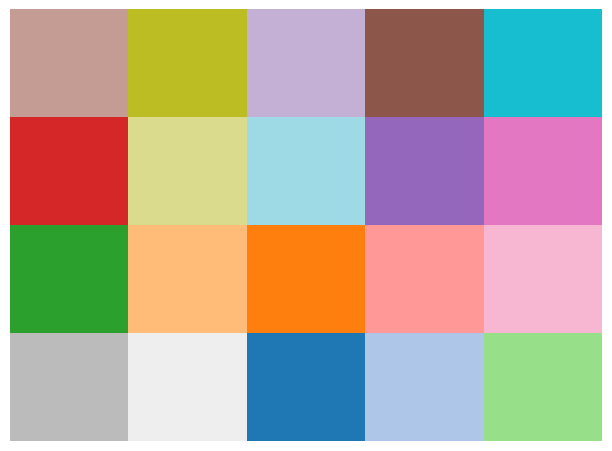

In [9]:
labels_grid = np.reshape(np.arange(max(bounds)), (4, 5))

fig, ax = plt.subplots(tight_layout=True, dpi=100)
ax.pcolormesh(labels_grid, cmap=cmap)
ax.axis("off")
fig.savefig(settings_seg.paper_dir / "labels_grid.pdf", bbox_inches="tight")

## Pipeline Image

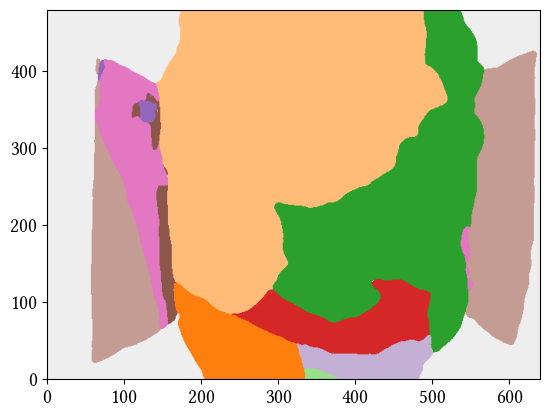

In [10]:
run_dir = settings.training_dir / "image" / df_runs.query('model == "image"')["run_hsi"].item()
example_id = "P058#2020_05_13_17_31_55"
preds = np.load(run_dir / "predictions" / f"{example_id}.npy")
preds = np.argmax(preds, axis=0)
preds_image = map_label_image(preds, label_mapping)

mpl.image.imsave(settings_seg.paper_dir / "example_prediction_image_hsi.png", preds_image)
plt.imshow(preds_image, origin="lower");

In [11]:
pd.read_pickle(run_dir / "validation_table.pkl.xz").query(
    "epoch_index == best_epoch_index and image_name == @example_id"
)

,epoch_index,best_epoch_index,dataset_index,fold_name,image_name,ce_loss,ece,dice_metric,used_labels,dice_metric_image,confusion_matrix,surface_distance_metric,surface_distance_metric_image,surface_dice_metric_mean,surface_dice_metric_image_mean
38160,79,79,0,"fold_P048,P057,P058",P058#2020_05_13_17_31_55,2.068835,"{'error': 0.8353394865989685, 'accuracies': [2...","[0.9795158, 0.98130256, 0.9917478, 0.98261726,...","[0, 3, 4, 5, 7, 10, 12, 13]",0.952653,"[[60968, 0, 0, 58, 33, 35, 0, 0, 0, 0, 36, 37,...","[0.8259689295227444, 0.8514327082450033, 1.394...",1.956777,"[0.8725281908808629, 0.7133620689655172, 0.975...",0.844604


## Example Image & Segmentation

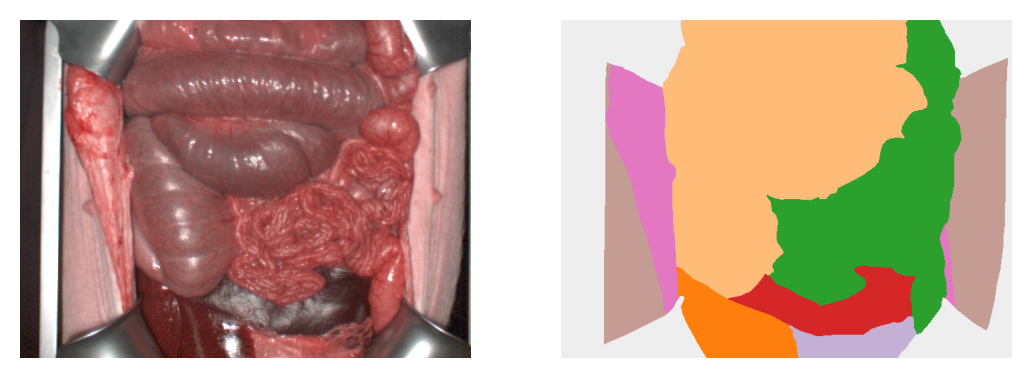

In [12]:
example_id = "P058#2020_05_13_17_31_55"
path = DataPath.from_image_name(example_id)
config = Config(
    {
        "label_mapping": label_mapping,
        "input/n_channels": 3,
        "input/preprocessing": None,
    }
)
sample = DatasetImage([path], train=False, config=config)[0]
seg_image = map_label_image(sample["labels"], label_mapping).numpy()
rgb = sample["features"].numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=200)
ax1.imshow(rgb, origin="lower")
ax1.axis("off")
ax2.imshow(seg_image, origin="lower")
ax2.axis("off");

## Graphical Abstract

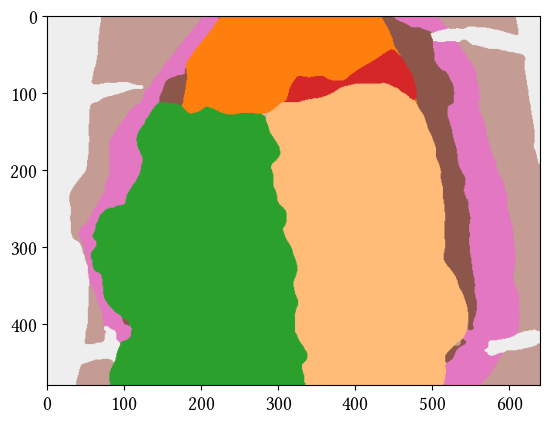

In [13]:
run_dir = settings.training_dir / "image" / df_runs.query('model == "image"')["run_hsi"].item()
# example_id = f'{df_dice.iloc[-4].subject_name}#{df_dice.iloc[-4].timestamp}'
example_id = "P044#2020_02_01_09_51_31"
preds = np.load(run_dir / "predictions" / f"{example_id}.npy")
preds = np.argmax(preds, axis=0)
preds_image = map_label_image(preds, label_mapping)

mpl.image.imsave(settings_seg.paper_dir / "example_prediction_abstract.png", preds_image)
plt.imshow(preds_image);

## Hidss Highlights

In [14]:
run_dir = settings.training_dir / "image" / df_runs.query('model == "image"')["run_hsi"].item()
config = Config(
    {
        "label_mapping": label_mapping,
        "input/n_channels": 3,
        "input/preprocessing": None,
    }
)

examples = [
    f"{df_dice.iloc[-10].subject_name}#{df_dice.iloc[-10].timestamp}",
    "P044#2020_02_01_09_51_31",
    f"{df_dice.iloc[-15].subject_name}#{df_dice.iloc[-15].timestamp}",
]
for example_id in examples:
    preds = np.load(run_dir / "predictions" / f"{example_id}.npy")
    preds = np.argmax(preds, axis=0)
    preds_image = map_label_image(preds, label_mapping)

    path = DataPath.from_image_name(example_id)
    sample = DatasetImage([path], train=False, config=config)[0]
    rgb = sample["features"].numpy()

    mpl.image.imsave(settings_seg.paper_dir / f"{example_id}_rgb.png", rgb)
    mpl.image.imsave(settings_seg.paper_dir / f"{example_id}_pred.png", preds_image)